## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm import tqdm

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

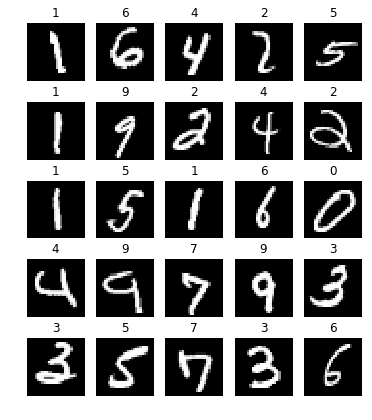

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [77]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean, std)

def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[1].std().data[0]
    print('backward', std)

In [88]:
# проверил и 1 и 0.1, при 1 по-сильнее расходится при backward

layers = [nn.Linear(784, 500), nn.Tanh()]
layers[0].register_forward_hook(forward_hook)
layers[0].register_backward_hook(backward_hook)
init_layer(layers[0], 0.0, 1)

for i in range(10):
    layers.append(nn.Linear(500, 500))
    layers[-1].register_forward_hook(forward_hook)
    layers[-1].register_backward_hook(backward_hook)
    init_layer(layers[-1], 0.0, 1)
    layers.append(nn.Tanh())

layers.append(nn.Linear(500, 10))
layers[-1].register_forward_hook(forward_hook)
layers[-1].register_backward_hook(backward_hook)
init_layer(layers[-1], 0.0, 1)

model = nn.Sequential(*layers)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [89]:
Z = Variable(torch.from_numpy(X), requires_grad=True)
p = Variable(torch.from_numpy(y), requires_grad=False)

activations = model(Z)
loss_fn = torch.nn.NLLLoss()
loss = loss_fn(activations, p)
loss.backward()

forward 0.941756010055542
forward 0.9841473698616028
forward 0.9815530776977539
forward 0.9811894297599792
forward 0.9810547828674316
forward 0.9814184308052063
forward 0.9816510677337646
forward 0.9819848537445068
forward 0.9821299910545349
forward 0.9824293255805969
forward 0.9825496077537537
forward 0.9813985824584961
backward 0.031220218166708946
backward 0.1081717386841774
backward 0.36859697103500366
backward 1.2646931409835815
backward 4.555929183959961
backward 15.262558937072754
backward 48.511741638183594
backward 164.79322814941406
backward 594.0238037109375
backward 1979.203125
backward 7263.6025390625
backward 24500.923828125


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [82]:
# Xavier

layers = [nn.Linear(784, 500), nn.Tanh()]
layers[0].register_forward_hook(forward_hook)
layers[0].register_backward_hook(backward_hook)
init_layer(layers[0], 0.0, np.sqrt(2.0 / 1284))

for i in range(10):
    layers.append(nn.Linear(500, 500))
    layers[-1].register_forward_hook(forward_hook)
    layers[-1].register_backward_hook(backward_hook)
    init_layer(layers[-1], 0.0, np.sqrt(0.002))
    layers.append(nn.Tanh())

layers.append(nn.Linear(500, 10))
layers[-1].register_forward_hook(forward_hook)
layers[-1].register_backward_hook(backward_hook)
init_layer(layers[-1], 0.0, np.sqrt(2.0 / 600))

model = nn.Sequential(*layers)

In [83]:
Z = Variable(torch.from_numpy(X), requires_grad=True)
p = Variable(torch.from_numpy(y), requires_grad=False)

activations = model(Z)
loss_fn = torch.nn.NLLLoss()
loss = loss_fn(activations, p)
loss.backward()

forward 0.941756010055542
forward 0.6407968997955322
forward 0.4899924397468567
forward 0.41118019819259644
forward 0.35947293043136597
forward 0.3219256103038788
forward 0.2928714454174042
forward 0.2675640285015106
forward 0.252127468585968
forward 0.2389817237854004
forward 0.22621752321720123
forward 0.21676427125930786
backward 0.0018024231540039182
backward 0.0017121146665886045
backward 0.001665522693656385
backward 0.0015671539586037397
backward 0.0014414365869015455
backward 0.0013443793868646026
backward 0.0012552767293527722
backward 0.0011460016248747706
backward 0.0010360234882682562
backward 0.0008681573672220111
backward 0.0006907456554472446
backward 0.00040505555807612836


In [84]:
# Xe

layers = [nn.Linear(784, 500), nn.ReLU()]
layers[0].register_forward_hook(forward_hook)
layers[0].register_backward_hook(backward_hook)
init_layer(layers[0], 0.0, np.sqrt(2.0 / 784))

for i in range(10):
    layers.append(nn.Linear(500, 500))
    layers[-1].register_forward_hook(forward_hook)
    layers[-1].register_backward_hook(backward_hook)
    init_layer(layers[-1], 0.0, np.sqrt(2.0 / 500))
    layers.append(nn.ReLU())

layers.append(nn.Linear(500, 10))
layers[-1].register_forward_hook(forward_hook)
layers[-1].register_backward_hook(backward_hook)
init_layer(layers[-1], 0.0, np.sqrt(2.0 / 500))

model = nn.Sequential(*layers)

In [85]:
Z = Variable(torch.from_numpy(X), requires_grad=True)
p = Variable(torch.from_numpy(y), requires_grad=False)

activations = model(Z)
loss_fn = torch.nn.NLLLoss()
loss = loss_fn(activations, p)
loss.backward()

forward 0.941756010055542
forward 0.7884056568145752
forward 0.7813846468925476
forward 0.7909021973609924
forward 0.7636898756027222
forward 0.7317594289779663
forward 0.7051092982292175
forward 0.7223301529884338
forward 0.7690080404281616
forward 0.7806901335716248
forward 0.7349286675453186
forward 0.7446820139884949
backward 0.0019394835690036416
backward 0.0019212585175409913
backward 0.0019015202997252345
backward 0.0018365242285653949
backward 0.0018282209057360888
backward 0.0018298111390322447
backward 0.0018141024047508836
backward 0.001781004830263555
backward 0.00169462023768574
backward 0.0016814394621178508
backward 0.0016801670426502824
backward 0.001349389087408781


<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [3]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.8):
        super(DropConnect, self).__init__()
        
        self.weights = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p
    
    def forward(self, x):
        m = Variable(torch.Tensor(*self.weights.size()).bernoulli_(self.p), requires_grad=False)
        output = torch.mm(x, m.mul(self.weights)).add_(self.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [262]:
modeldrop = nn.Sequential(nn.Linear(784, 200), nn.Dropout(), nn.ReLU(), 
                         nn.Linear(200, 200), nn.Dropout(), nn.ReLU(), 
                         nn.Linear(200, 10), nn.LogSoftmax())

In [263]:
loss_nf = nn.NLLLoss()
optimiser = torch.optim.Adam(params=modeldrop.parameters(), lr=0.001)

In [264]:
losses = np.zeros(40)

for epoch in tqdm(range(40)):
    for X, y in train_loader:
        out = modeldrop(Variable(X.view(X.size(0), -1)))
        loss = loss_nf(out, Variable(y, requires_grad=False))
        losses[epoch] = max(losses[epoch], abs(loss.data[0]))
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

100%|██████████| 40/40 [08:45<00:00, 15.03s/it]


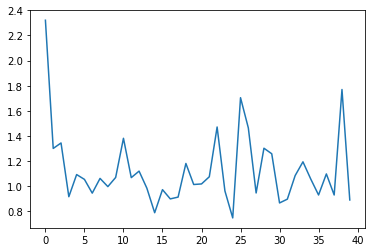

In [265]:
plt.plot([i for i in range(40)], losses)

In [315]:
out = modeldrop(Variable(X.view(X.size(0), -1)))
pred = out.data.numpy().argmax(axis=1)

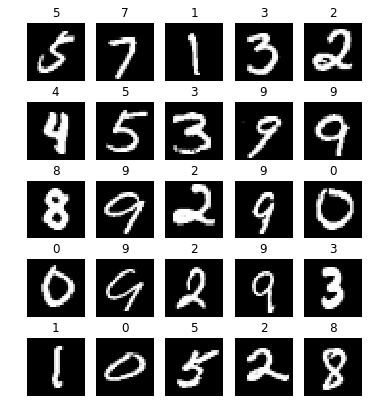

In [316]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X.view(X.size(0), -1).numpy()[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(pred[i])
    plt.axis('off')

In [7]:
modeldropcon = nn.Sequential(DropConnect(784, 200, .8), nn.ReLU(), 
                         DropConnect(200, 200, .8), nn.ReLU(), 
                         DropConnect(200, 10, .8), nn.LogSoftmax())
loss_fn2 = nn.NLLLoss()
optimiser2 = torch.optim.Adam(params=modeldropcon.parameters(), lr=0.001)

In [8]:
losses = np.zeros(40)

for epoch in tqdm(range(40)):
    for X, y in train_loader:
        out = modeldropcon(Variable(X.view(X.size(0), -1)))
        loss = loss_fn2(out, Variable(y, requires_grad=False))
        losses[epoch] = max(losses[epoch], abs(loss.data[0]))
        
        optimiser2.zero_grad()
        loss.backward()
        optimiser2.step()

100%|██████████| 40/40 [11:30<00:00, 19.43s/it]


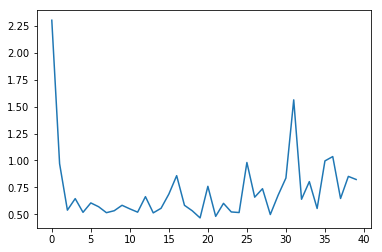

In [9]:
plt.plot([i for i in range(len(losses))], losses)

In [10]:
out = modeldropcon(Variable(X.view(X.size(0), -1)))
pred = out.data.numpy().argmax(axis=1)

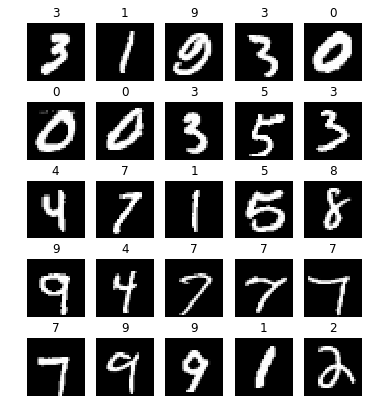

In [12]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X.view(X.size(0), -1).numpy()[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(pred[i])
    plt.axis('off')

<i> 2.3 Сделайте выводы по третьей части </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [65]:
# полезные функции: .std(dim), .mean(dim)
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = torch.div(x.sub(x.mean(dim=1).view(-1, 1).expand(*x.size())), x.std(dim=1).view(-1, 1).expand(*x.size()))
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [82]:
modellayernorm = nn.Sequential(nn.Linear(784, 200), nn.ReLU(), LayerNormalization(), 
                         nn.Linear(200, 200), nn.ReLU(), LayerNormalization(), 
                         nn.Linear(200, 10), nn.LogSoftmax())
loss_fn3 = nn.NLLLoss()
optimiser3 = torch.optim.Adam(params=modellayernorm.parameters(), lr=0.001)

In [83]:
losses = np.zeros(20)

for epoch in tqdm(range(20)):
    for X, y in train_loader:
        out = modellayernorm(Variable(X.view(X.size(0), -1)))
        loss = loss_fn3(out, Variable(y, requires_grad=False))
        losses[epoch] = max(losses[epoch], abs(loss.data[0]))
        
        optimiser3.zero_grad()
        loss.backward()
        optimiser3.step()

100%|██████████| 20/20 [04:39<00:00, 14.01s/it]


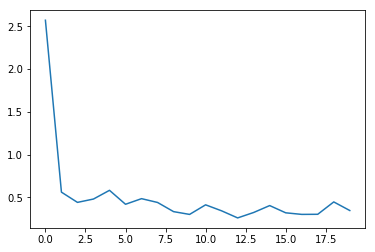

In [84]:
plt.plot([i for i in range(len(losses))], losses)

In [85]:
out = modellayernorm(Variable(X.view(X.size(0), -1)))
pred = out.data.numpy().argmax(axis=1)

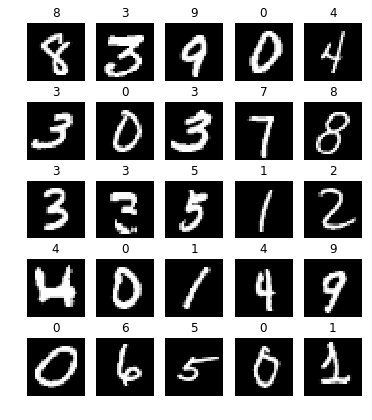

In [86]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X.view(X.size(0), -1).numpy()[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(pred[i])
    plt.axis('off')

In [90]:
modelbatchnorm = nn.Sequential(nn.Linear(784, 200), nn.ReLU(), nn.BatchNorm1d(200),
                         nn.Linear(200, 200), nn.ReLU(), nn.BatchNorm1d(200),
                         nn.Linear(200, 10), nn.LogSoftmax())
loss_fn4 = nn.NLLLoss()
optimiser4 = torch.optim.Adam(params=modelbatchnorm.parameters(), lr=0.001)

In [91]:
losses = np.zeros(20)

for epoch in tqdm(range(20)):
    for X, y in train_loader:
        out = modelbatchnorm(Variable(X.view(X.size(0), -1)))
        loss = loss_fn4(out, Variable(y, requires_grad=False))
        losses[epoch] = max(losses[epoch], abs(loss.data[0]))
        
        optimiser4.zero_grad()
        loss.backward()
        optimiser4.step()

100%|██████████| 20/20 [06:01<00:00, 18.63s/it]


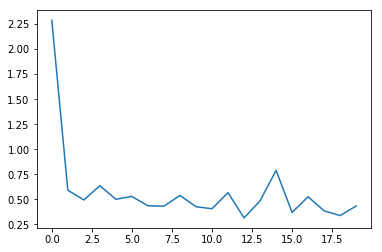

In [92]:
plt.plot([i for i in range(len(losses))], losses)

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: